### Introduction

It is often the case that one is interested in interrogating whether a region of the genome harbors allelic imbalance. This is usually an interesting questions, as it make indicate loss of heterozygosity (LOH) in proximity of a funcitonally relevant gene. 

Initially, it may seem that qualitative inspection of the minor allele frequency (maf) distributions of germline heterozygous variants should be able to answer the above quesion. However, it turns out that in presence of moderate to high normal cell contamination, using pre-determined thresholds for maf may result in loss of sensitivity. 

To resolve issue, we will formulate a systematic approach to select the maf threshold using the simulation experiment below. Inputs to this experiment are the tumor sample purity (1 - normal cell contamination), average sequencing depth of coverage, and the allele specific copy number values of the alteration we are trying to identify. In case of one copy loss of a genomic region (typicall scenario for LOH), minor and major tumor copy numbers will be $n_{A}=0$ and $n_{B}=1$, respectively. 

### Implementation

In [478]:
#! /usr/bin/env python
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline
import matplotlib.pyplot as plt
        

from matplotlib import style
style.use('seaborn-talk')
# style.use('classic')


In [479]:
# experiment input parameters
coverage = 190
purity = 0.3
nA = 0
nB = 1
sampleSize = 1000 # number of simulation samples. Determines the variance of optimized threshods

Based on the input parameters, we can calculate the expected values of minor allele frequency in tumor and normal samples as follows. 

$$ MAF_{normal} = \frac{1}{2} $$

$$ MAF_{tumor} = \frac{n_{A} * p + (1-p)}{(n_{A} + n_{B}) * p + 2 * (1-p)}$$

Where $p$ represents tumor purity (between 0 and 1).

In [480]:
# define expected b-allele frequency in tumor and normal samples
normalMAF = 0.5
tumorMAF = (nA * purity + (1-purity))/((nA+nB)* purity + 2 * (1-purity))

At this point, let's generate a sample of size `sampleSize` from each one of normal and tumor SNP populations.

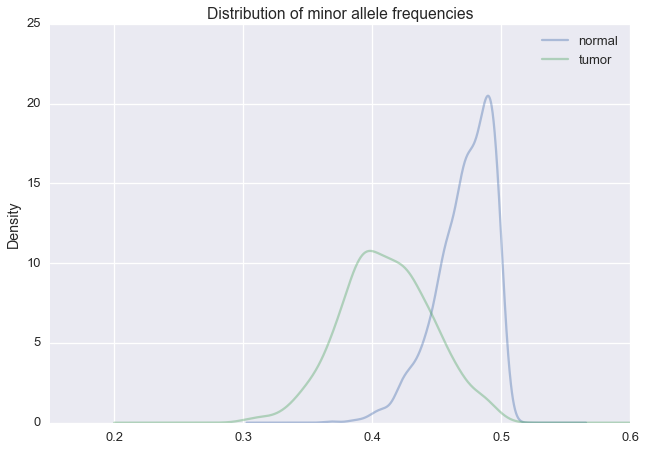

190 1000


In [481]:
# We will use a binomial process to simulate the sampling of minor allele 
# from the pool of all reads covering the SNP of interest
normalCounts = np.random.binomial(n = coverage, p = normalMAF, size = sampleSize)
tumorCounts = np.random.binomial(n = coverage, p = tumorMAF, size = sampleSize)
normalAF = normalCounts / float(coverage)
tumorAF = tumorCounts / float(coverage)

# Since we use minor allele frequency of SNP to determine LOH, let's make sure all fractions above are below 0.5
normalMAF = np.minimum(normalAF, 1 - normalAF)
tumorMAF = np.minimum(tumorAF, 1 - tumorAF)


MAFs = np.concatenate([normalMAF, tumorMAF], axis = 0)
source =  ['normal'] * sampleSize + ['tumor'] * sampleSize


data = pd.DataFrame({'MAF': MAFs, 'source': pd.Categorical(source)})

plt.figure()
data.groupby("source").MAF.plot(kind = 'kde', alpha=0.4, title = "Distribution of minor allele frequencies")
plt.legend()
plt.show()

print coverage, sampleSize

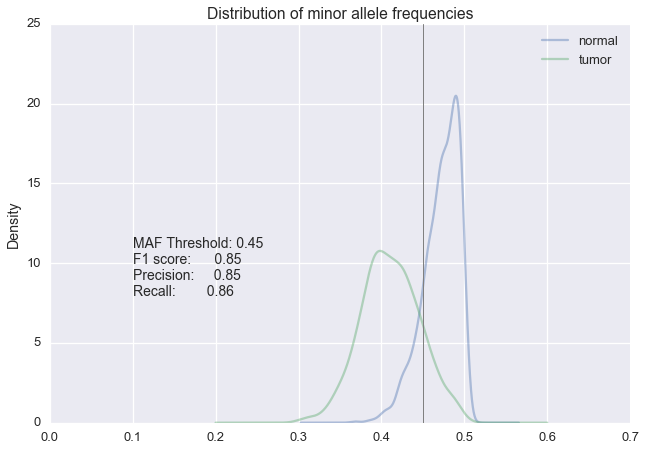

In [482]:
# identifying the optimal threshold
thresholds = [i * 0.01 for i in range(101)]
results = []
for threshold in thresholds:
    TP = np.shape(np.where(tumorMAF <= threshold))[1]
    TN = np.shape(np.where(normalMAF > threshold))[1]
    FP = np.shape(np.where(normalMAF <= threshold))[1]
    FN = np.shape(np.where(tumorMAF > threshold))[1]
    if TP + FP == 0:
        continue
    precision = float(TP) / (TP + FP)
    recall = float(TP) / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)
    results.append((threshold,
                    F1, precision, recall))
    
# identify the threshold with max F1 score
thresholds, F1s, precisions, recalls = zip(*results)

optIndex = np.argmax(F1s)
F1 = np.round(F1s[optIndex],2)
threshold = np.round(thresholds[optIndex],2)
precision = np.round(precisions[optIndex],2)
recall = np.round(recalls[optIndex],2)

plt.figure()
data.groupby("source").MAF.plot(kind = 'kde', alpha=0.4, title = "Distribution of minor allele frequencies", xlim = [0,0.7])
plt.axvline(x = threshold, color = 'gray', linewidth = 1)
plt.legend()
plt.text(0.1, 11, 'MAF Threshold: %0.2f'%threshold, fontsize = 14)
plt.text(0.1, 10, 'F1 score:      %0.2f'%F1, fontsize = 14)
plt.text(0.1, 9, 'Precision:     %0.2f'%precision, fontsize = 14)
plt.text(0.1, 8, 'Recall:        %0.2f'%recall, fontsize = 14)
plt.show()


In [490]:
purities = [x * 0.01 + 0.05 for x in range(1,96)]
coverages = [x * 5 + 50 for x in range(61)]
thresholds = [i * 0.01 for i in range(101)]

nA = 0
nB = 1

# purities = [0.35, 0.9]
# coverages = [50, 90, 150, 1000]
master = []
# fig, ax = plt.subplots(4)

for purity in purities:
    for coverage in coverages:
        index = coverages.index(coverage)
        normalMAF = 0.5
        tumorMAF = (nA * purity + (1-purity))/((nA+nB)* purity + 2 * (1-purity))
        
        normalCounts = np.random.binomial(n = coverage, p = normalMAF, size = sampleSize)
        tumorCounts = np.random.binomial(n = coverage, p = tumorMAF, size = sampleSize)
        normalAF = normalCounts / float(coverage)
        tumorAF = tumorCounts / float(coverage)
        normalMAF = np.minimum(normalAF, 1 - normalAF)
        tumorMAF = np.minimum(tumorAF, 1  - tumorAF)
        # print index, coverage, np.var(normalMAF), np.var(tumorMAF)
        
        # MAFs = np.concatenate([normalMAF, tumorMAF], axis = 0)
        # source =  ['normal'] * sampleSize + ['tumor'] * sampleSize
        # data = pd.DataFrame({'MAF': MAFs, 'source': pd.Categorical(source)})
        # data.groupby("source").MAF.plot(kind = 'kde', alpha=0.4, title = "", xlim = [0,0.7], ax = ax[index])
        # plt.legend()
        
        results = []
        for threshold in thresholds:
            TP = np.shape(np.where(tumorMAF <= threshold))[1]
            TN = np.shape(np.where(normalMAF > threshold))[1]
            FP = np.shape(np.where(normalMAF <= threshold))[1]
            FN = np.shape(np.where(tumorMAF > threshold))[1]
            if TP + FP == 0:
                continue
            precision = float(TP) / (TP + FP)
            recall = float(TP) / (TP + FN)
            if precision + recall == 0:
                continue
            F1 = 2 * precision * recall / (precision + recall)
            results.append((threshold,
                            F1, precision, recall))
        thresholds, F1s, precisions, recalls = zip(*results)

        optIndex = np.argmax(F1s)
        F1 = np.round(F1s[optIndex],2)
        threshold = np.round(thresholds[optIndex],2)
        precision = np.round(precisions[optIndex],2)
        recall = np.round(recalls[optIndex],2)
        # print [purity, coverage, threshold, F1, precision, recall]
        master.append([purity, coverage, threshold, F1, precision, recall])



At this point, we can systematically query the distribution of optimal F1 score, precision, or recall over a grid of typical values of coverage, and purity.

We can also mark the samples in current cohort in purity by coverage plane.

In [484]:
samples = []
f_h = file('sample.info')
header = f_h.readline()

points = []
for line in f_h:
    sample, purity, coverage = line.strip().split('\t')
    purity =float(purity)
    coverage = int(coverage)
    
    dist = [abs(gridPurity - purity) for gridPurity in purities]
    closestPurity = purities[np.argmin(dist)]
    dist = [abs(gridCoverage - coverage) for gridCoverage in coverages]
    closestCoverage = coverages[np.argmin(dist)]
    
    points.append([closestPurity, closestCoverage, sample])
    
sampleData = points

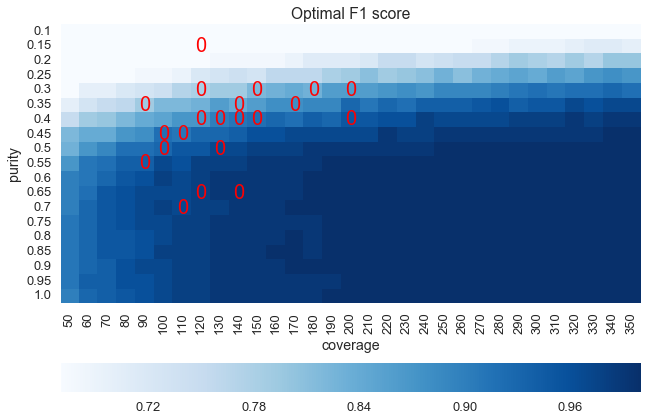

In [485]:
purity, coverage, threshold, F1, precision, recall = zip(*master)

import matplotlib.cm as CM
sns.light_palette((210, 90, 60), input="husl")

F1Plot = pd.DataFrame({'purity': purity, 'coverage': coverage, 'F1': F1})
F1Plot = F1Plot.pivot("purity", "coverage", "F1")

labels = 1 - np.zeros_like(F1Plot)
for p, c, s in sampleData:
    purityIndex = np.where(abs(np.array(purities) - p) < 0.01)
    coverageIndex = np.where(abs(np.array(coverages) - c) < 0.01)
    labels[purityIndex, coverageIndex] = 0

#print F1Plot.columns
labels = F1Plot.copy()
labels.iloc[:]= 1
for p, c, s in sampleData:
    purityIndex = np.where(abs(np.array(purities) - p) < 0.01)
    coverageIndex = np.where(abs(np.array(coverages) - c) < 0.01)
    labels.iloc[purityIndex, coverageIndex] = 0 


mask = labels.astype('bool')

sns.heatmap(F1Plot,cbar_kws={"orientation": "horizontal"}, cmap = "Blues")
sns.plt.title('Optimal F1 score')

sns.heatmap(labels,cbar_kws={"orientation": "horizontal"}, alpha = 0.0, annot = True, cbar = False,\
          mask = mask, annot_kws={"size": 20, 'color':'red'})




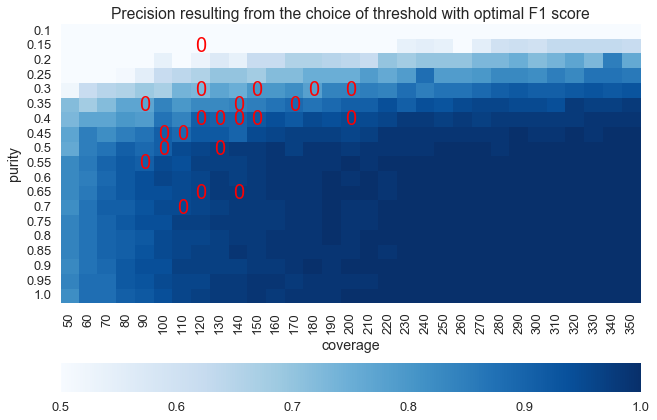

In [486]:
precPlot = pd.DataFrame({'purity': purity, 'coverage': coverage, 'precision': precision})
precPlot = precPlot.pivot("purity", "coverage", "precision")
sns.heatmap(precPlot,cbar_kws={"orientation": "horizontal"}, cmap = 'Blues')
sns.plt.title('Precision resulting from the choice of threshold with optimal F1 score')
sns.heatmap(labels,cbar_kws={"orientation": "horizontal"}, alpha = 0.0, annot = True, cbar = False,\
          mask = mask, annot_kws={"size": 20, 'color':'red'})


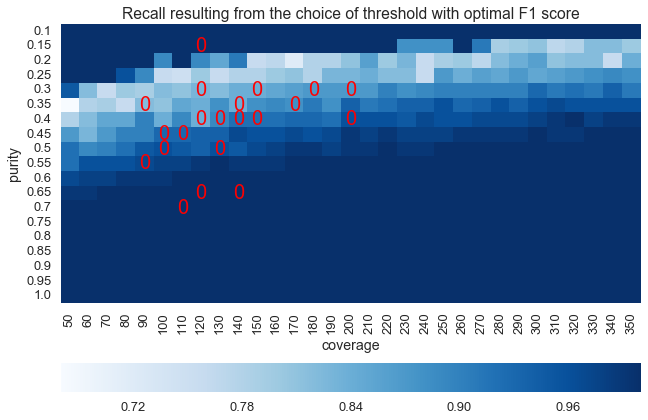

In [487]:
recPlot = pd.DataFrame({'purity': purity, 'coverage': coverage, 'recall': recall})
recPlot = recPlot.pivot("purity", "coverage", "recall")
sns.heatmap(recPlot,cbar_kws={"orientation": "horizontal"}, cmap = 'Blues')
sns.plt.title('Recall resulting from the choice of threshold with optimal F1 score')
sns.heatmap(labels,cbar_kws={"orientation": "horizontal"}, alpha = 0.0, annot = True, cbar = False,\
          mask = mask, annot_kws={"size": 20, 'color':'red'})



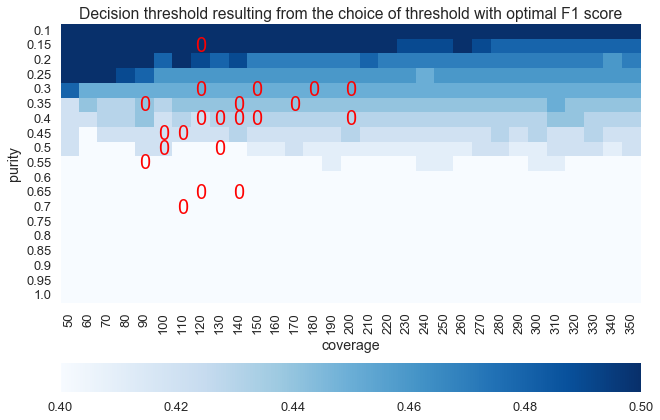

In [488]:
thrPlot = pd.DataFrame({'purity': purity, 'coverage': coverage, 'threshold': threshold})
thrPlot = thrPlot.pivot("purity", "coverage", "threshold")
sns.heatmap(thrPlot,cbar_kws={"orientation": "horizontal"}, cmap = 'Blues')
sns.plt.title('Decision threshold resulting from the choice of threshold with optimal F1 score')
sns.heatmap(labels,cbar_kws={"orientation": "horizontal"}, alpha = 0.0, annot = True, cbar = False,\
          mask = mask, annot_kws={"size": 20, 'color':'red'})
